# Imports

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import distribution_generator as dg
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches



from random import lognormvariate, normalvariate

from sklearn.neighbors import KernelDensity

import imports
import os
import json

from IPython.display import Audio
sound_file = './call.wav'
ALLERT = Audio(url=sound_file, autoplay=True)

In [2]:
def log_progress(sequence, every=None, size=None):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = size / 200     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{index} / ?'.format(index=index)
                else:
                    progress.value = index
                    label.value = u'{index} / {size}'.format(
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = str(index or '?')

# Read part

In [3]:
def plotDensity(densities, log_flag = False, height = 4, width = 12, left = None, right = None, axes_limits = None,
               colors = None, name = None):
    
    if type(densities[0]) != list and type(densities[0]) != np.ndarray:
        densities = [densities]
    fig = plt.figure(figsize=(width, height))
    ax = fig.add_subplot(1,1,1)

    if axes_limits:
        ax.axis(axes_limits)
        ax = plt.gca()
        ax.set_autoscale_on(False)

    if left is None:
        left = 0
    if right is None:
        right = len(densities[0])
        
    for i in range(len(densities)):
        density = densities[i]
        if colors is None:
            ax.plot(density[left : right])
        else:
            ax.plot(density[left : right], colors[i])
   
    if not name is None: 
        fig.savefig(name)
    if log_flag:
        ax.set_xscale('log')
        ax.set_yscale('log')
    plt.show()

In [4]:
runs_dir = "/home/anton/azul/New_config_latency_runs/all0408RD/"


runs = dict(zip(['Dev', 'Granada', 'Highlander'], [[],[],[]]))

for run_file_name in os.listdir(runs_dir):
    if run_file_name.endswith("READ.rd"):
        x, curr_pdf, curr_cdf = imports.readRD(run_file_name, runs_dir, scale = True)
        
        
        if run_file_name.split('-')[3] == '600':
            runs[run_file_name.split('-')[0]].insert(0, curr_pdf)
        if run_file_name.split('-')[3] == '1800':
            runs[run_file_name.split('-')[0]].append(curr_pdf)
        
        print run_file_name

asasas
Granada-d-10000-600-2016.04.08-13.27.33-ycsb-run-READ.rd
asasas
Highlander-d-10000-1800-2016.04.08-09.16.33-ycsb-run-READ.rd
asasas
Dev-d-10000-1800-2016.04.08-15.59.41-ycsb-run-READ.rd
asasas
Highlander-d-10000-1800-2016.04.08-08.44.09-ycsb-run-READ.rd
asasas
Granada-d-10000-600-2016.04.08-13.15.11-ycsb-run-READ.rd
asasas
Dev-d-10000-600-2016.04.08-15.34.53-ycsb-run-READ.rd
asasas
Dev-d-10000-600-2016.04.08-15.47.16-ycsb-run-READ.rd
asasas
Granada-d-10000-1800-2016.04.08-14.44.42-ycsb-run-READ.rd
asasas
Highlander-d-10000-600-2016.04.08-08.19.19-ycsb-run-READ.rd
asasas
Highlander-d-10000-1800-2016.04.08-09.48.58-ycsb-run-READ.rd
asasas
Granada-d-10000-600-2016.04.08-13.02.39-ycsb-run-READ.rd
asasas
Dev-d-10000-600-2016.04.08-15.22.26-ycsb-run-READ.rd
asasas
Granada-d-10000-1800-2016.04.08-13.39.55-ycsb-run-READ.rd
asasas
Highlander-d-10000-600-2016.04.08-08.06.57-ycsb-run-READ.rd
asasas
Granada-d-10000-1800-2016.04.08-14.12.18-ycsb-run-READ.rd
asasas
Highlander-d-10000-600-2016

# Usefull Funcs

In [5]:
def searchBoarders(density, i, bw):
    left_boarder = i
    right_boarder = i
    
    if bw % 2 == 0:
        bw += 1
        
    right_saturation = (bw - 1) / 2
    left_saturation = (bw - 1) / 2
    
    while left_saturation > 0 and left_boarder > 0:
        if density[left_boarder] > 0:
            left_saturation -= 1
        left_boarder -= 1
    
    while right_saturation > 0 and right_boarder < len(density) - 1:
        if density[right_boarder] > 0:
            right_saturation -= 1
        right_boarder += 1
        
    if right_saturation == 0 and left_saturation == 0:
        return left_boarder, right_boarder
    elif right_saturation == 0 and left_saturation != 0:
        return max(0, right_boarder - i), right_boarder
    elif left_saturation == 0 and right_saturation != 0:
        return left_boarder, i + i - left_boarder
    else:
        return 0, len(density)

In [6]:
def flattenDensities(densities, bw = 3): 
    #max_bw = np.where(density > 0)[0][0]
    new_densities = []
    
    if type(densities[0]) != np.ndarray and type(densities[0]) != list:
        #print 'Type changing...'
        densities = [densities]
        
    for density in densities:

        new_density = np.zeros(len(density)*2)

        saturation = 0

        for i in range(len(density)):
            if density[i] == 0:
                pass
            else:
                left_boarder, right_boarder = searchBoarders(density, i, bw)
                for j in range(left_boarder, right_boarder):
                    new_density[j] += density[i] / (right_boarder - left_boarder)
        
        new_densities.append(new_density)

    return new_densities
    

In [7]:
def sampleFromDensity(densities, sample_size = 1000, scaling = False, noisy = False, noise_scale = 1.0):
    
    if type(densities[0]) != np.ndarray and type(densities[0]) != list:
        #print 'Type changing...'
        densities = [densities]
    
    sample = np.empty(0)
    for density in densities:
        if scaling:
            density = density / sum(density)
        if noisy:
            noise = generateNoiseMeansPattern(sample_size / len(densities), noise_scale)
        else:
            noise = np.zeros(sample_size / len(densities))
        curr_sample = np.random.choice(range(len(density)), sample_size / len(densities), p = density) + noise
        sample = np.hstack((sample, curr_sample))
    return sample

In [8]:
def densityFromSample(sample, normed = True):
    return np.histogram(sample, bins=round(max(sample) + 1) , 
                        density=True, range = (0, round(max(sample) +1)))

In [9]:
def bootstrap(pdfs, statistics_set, statistics_names, stat_sample_size = 6, sample_size = 1000, scaling = False,
              noisy = False):
    
    if len(statistics_set) != len(statistics_names):
        raise AttributeError("Statistics_names and statistics_set should have the same lenghth,\
        also Statistics_names shold be unique!")
    
    statistics_vals = dict(zip(statistics_names, [[] for _ in range(len(statistics_names))]))
    
    for i in log_progress(range(stat_sample_size), every=1):
        sample = (sampleFromDensity(pdfs, sample_size, scaling = scaling))
        for j in range(len(statistics_set)):
            
            statistics_vals[statistics_names[j]].append(statistics_set[j](sample))
    
    return statistics_vals

In [10]:
def readRDHeader(file_name, file_dir, header_size = 12):
    f = open(file_dir+file_name, 'r')
    header = dict()
    
    for i in range(header_size):
        s = f.readline()
        key = s.split('=')[0]
        val = s.split('=')[1].replace(',', '.')
        if key.endswith('ptile'):
            key = float(key[:-5].replace(',', '.'))
        header[key] = float(val)
    
    return header

In [11]:
def pdfPercentiles(pdf, perc, strat = 'first_higher'):
    perc_normed = float(perc)/ 100
    curr_perc = 0.0
    
    i = 0 
    last_grow = 0
    while curr_perc < perc_normed and i < len(pdf):
        curr_perc += pdf[i]
        if pdf[i] > 0 and curr_perc < perc_normed: 
            last_grow = i
        i += 1
    
    if curr_perc >= perc_normed:
        if strat == 'first_higher':
            return i
        else:
            return last_grow
    else:
        return -1         

In [12]:
def _parseArgs(args):
    return args[0], args[1], args[2]

In [13]:
def genCheck(pdf):
    check = dict()

    check_sample = sampleFromDensity(pdf, sample_size=4000000)
    for i in range(len(stats_funcs)):
        check[stats_names[i]] = stats_funcs[i](check_sample)
        
    return check

# Full algorithm

In [14]:
class Hypothesis():
    
    def __init__(self, name, stat_means, stat_stds):
        self.name = name
        self.means = stat_means
        self.stds = stat_stds
        self.stat_names = stat_means.keys()
    
    def __str__(self):
        
        return self.name + '\n means: \n' + self.means.__str__() + '\n stds: \n' + self.stds.__str__()

In [15]:
def generateAlternative(base_hypothesis, shift_directions, alpha = 0.01):
    alt_means = dict()
    alt_stds = dict()
    
    for key in shift_directions:
        alt_means[key] = base_hypothesis.means[key] * (1 + alpha * shift_directions[key])
        alt_stds[key] = base_hypothesis.stds[key] 
      
    alternative = Hypothesis(
                                name = 'alternative: ' + ' '.join(map(str, shift_directions.values())),
                                stat_means = alt_means,
                                stat_stds = alt_stds
                                )
    
    return alternative

In [16]:
def sampleFromHypothesis(hypothesis, sample_size = 1):
    sample = dict()
    
    for key in hypothesis.stat_names:
        sample[key] = stats.norm(hypothesis.means[key], hypothesis.stds[key]).rvs(sample_size)
    
    return sample

In [17]:
def singleNPStat(zero, alternative, sample, v = True):
    '''
        Calculate Neyman-Pearson statistic for two normal distributions 
    '''
    stat = 0
    

    for key in zero.stat_names:
        if np.log(stats.norm(zero.means[key], zero.stds[key]).pdf(sample[key]) /\
                       stats.norm(alternative.means[key], alternative.stds[key]).pdf(sample[key])) != np.nan:
            stat += np.log(stats.norm(zero.means[key], zero.stds[key]).pdf(sample[key]) /\
                           stats.norm(alternative.means[key], alternative.stds[key]).pdf(sample[key])) /\
                            len(zero.stat_names)
            
        print zero.means[key]
        print alternative.means[key]
        print zero.stds[key]
        print sample[key]
        #print alternative.stds[key]
        #
        print stats.norm(zero.means[key], zero.stds[key]).pdf(sample[key])
        
        print stats.norm(alternative.means[key], alternative.stds[key]).pdf(sample[key])
        #print stat

    if v:
        print zero.name
        print alternative.name
        print stat
        print "----------------------"
        
    return stat

In [18]:
def NPStatDistribution(zero, alternative, sample_size = 100):
    
    zero_np_stat_samp = np.zeros(sample_size)
    alternative_np_stat_samp = np.zeros(sample_size)
    
    zero_sample = sampleFromHypothesis(zero, sample_size=sample_size)
    alternative_sample = sampleFromHypothesis(alternative, sample_size=sample_size)
    
    
    for i in log_progress(range(sample_size), every = 1):
        for key in zero.stat_names:
            zero_np_stat_samp[i] += np.log(stats.norm(zero.means[key], zero.stds[key]).pdf(zero_sample[key][i]) /\
                                           stats.norm(alternative.means[key], alternative.stds[key]).pdf(zero_sample[key][i])) /\
                                            len(zero.stat_names)
            alternative_np_stat_samp[i] += np.log(stats.norm(zero.means[key], zero.stds[key]).pdf(alternative_sample[key][i]) /\
                            stats.norm(alternative.means[key], alternative.stds[key]).pdf(alternative_sample[key][i])) /\
                            len(zero.stat_names)
          
    zero_np_hist = np.histogram(zero_np_stat_samp, bins=len(zero_np_stat_samp))
    alternative_np_hist = np.histogram(alternative_np_stat_samp, bins = len(zero_np_stat_samp))
    return zero_np_hist, alternative_np_hist

In [19]:
def doAll(base_sample, check, params, base_pdf = None):
    if base_pdf is None:
        base_pdf = densityFromSample(base_sample)[0]
        
    print base_pdf
    statistics_set, statistics_names, bw = _parseArgs(params)
    
    base_pdf_smoothed = flattenDensities(base_pdf, bw=bw)
    
    statistics_vals = bootstrap(base_pdf_smoothed, statistics_set, statistics_names, sample_size=400000)
    
    statistics_means = dict()
    statistics_stds = dict()
    
    for key in statistics_vals:
        statistics_means[key] = np.mean(statistics_vals[key])
        statistics_stds[key] = np.std(statistics_vals[key])
     
    zero_hypothesis = Hypothesis('zero_H', statistics_means, statistics_stds)
    
    ### create two basic alternatives, will improve later
    right_shifts = dict()
    left_shifts = dict()
    for name in statistics_names:
        right_shifts[name] = 1
        left_shifts[name] = -1
    
    right_alternative = generateAlternative(zero_hypothesis, right_shifts, alpha = 0.2)
    left_alternative = generateAlternative(zero_hypothesis, left_shifts, alpha = 0.2)
    
    singleNPStat(zero_hypothesis, right_alternative, check)
    singleNPStat(zero_hypothesis, left_alternative, check)
    
    NP_plot = False
    if NP_plot:
        zero_np_hist, right_alt_np_hist = NPStatDistribution(zero_hypothesis, right_alternative, sample_size = 1000)
        zero_np_hist, left_alt_np_hist = NPStatDistribution(zero_hypothesis, left_alternative, sample_size = 1000)

        plt.bar(zero_np_hist[1][:-1], zero_np_hist[0], align='center', width=np.diff(zero_np_hist[1]),color = 'b', edgecolor = 'b')
        plt.bar(right_alt_np_hist[1][:-1], right_alt_np_hist[0], align='center', width=np.diff(right_alt_np_hist[1]),color = 'g', edgecolor = 'g')
        plt.show()
    
    #print zero_hypothesis
    #print "\n"
    #print right_alternative
 
    

In [20]:
def genGCpauseEmulation(pdf, incr, percentage, sample_size = 4000000):
    sample = sampleFromDensity(pdf, sample_size=sample_size)
    
    increase_num = sample_size * percentage / 100
    
    mask = np.zeros(sample_size)
    
    mask[np.random.randint(0, sample_size, int(increase_num))] = incr
    
    sample += mask
    
    return sample

In [21]:
stats_funcs = [#np.mean,
                #lambda x : np.percentile(x, 50),
                lambda x : np.percentile(x, 99.9),
                lambda x : np.percentile(x, 99.99),
                lambda x : np.percentile(x, 99.999),
              ]
stats_names = [#'mean',
               #50,
               #90,
                99.9,
               99.99,
                99.999
              ]

In [22]:
doAll(_, genCheck(runs['Dev'][0]), [stats_funcs, stats_names, 3], runs['Highlander'][1])

[ 0.  0.  0. ...,  0.  0.  0.]
7373.85278332
8848.62333999
297.255500238
8215.0
2.44920178694e-05
0.000138402651884
2311.67083333
2774.005
80.9737139086
2425.0
0.00185017547765
4.55643771104e-07
23406.67608
28088.011296
3284.12758381
19055.00128
5.04922667683e-05
2.7650985079e-06
zero_H
alternative: 1 1 1
3.16066791141
----------------------
7373.85278332
5899.08222666
297.255500238
8215.0
2.44920178694e-05
8.85135918067e-17
2311.67083333
1849.33666667
80.9737139086
2425.0
0.00185017547765
5.21910702537e-14
23406.67608
18725.340864
3284.12758381
19055.00128
5.04922667683e-05
0.000120865413584
zero_H
alternative: -1 -1 -1
16.5882483331
----------------------


# NEW TYPE CHECK. SURVIVAL

In [23]:
import data_processing_utils as utils

oracle_dir = "/home/anton/azul/New_config_latency_runs/OracleRD/"
dev_dir = "/home/anton/azul/New_config_latency_runs/DevRD/"
highlander_dir = "/home/anton/azul/New_config_latency_runs/HighlanderRD/"

oracle_runs = utils.read_multiple(oracle_dir, ["READ"], verbouse=False)
dev_runs = utils.read_multiple(dev_dir, ["READ"], verbouse=False)
highlander_runs = utils.read_multiple(highlander_dir, ["READ"], verbouse=False)

In [34]:
doAll(_, genCheck(dev_runs[1]),
      [stats_funcs, stats_names, 3], 
      dev_runs[3])

[ 0.  0.  0. ...,  0.  0.  0.]
1638.33621667
1720.2530275
354.661476487
0.00111358138121
0.00104930290416
zero_H
alternative: 1
0.0594552481119
----------------------
1638.33621667
1556.41940583
354.661476487
0.00111358138121
0.00112040312335
zero_H
alternative: -1
-0.00610726110489
----------------------


In [253]:
dev_samples = [sampleFromDensity(pdf, sample_size=4000000) for pdf in runs["Highlander"][:3] + runs["Highlander"][4:]]

In [254]:
statistics_vals = dict()

for i in range(len(stats_names)):
    statistics_vals[stats_names[i]] = []
    
    for j in range(len(dev_samples)):
        statistics_vals[stats_names[i]].append(stats_funcs[i](dev_samples[j]))

In [255]:
dev_stats = dict()

statistics_means = dict()
statistics_stds = dict()
    
for key in statistics_vals:
    statistics_means[key] = np.mean(statistics_vals[key])
    statistics_stds[key] = np.std(statistics_vals[key])
     
zero_hypothesis = Hypothesis('zero_H', statistics_means, statistics_stds)
right_shifts = dict()
left_shifts = dict()
for name in stats_names:
    right_shifts[name] = 1
    left_shifts[name] = -1
right_alternative = generateAlternative(zero_hypothesis, right_shifts, alpha = 0.1)
left_alternative = generateAlternative(zero_hypothesis, left_shifts, alpha = 0.1)

In [256]:
plt.plot(stats.norm(zero_hypothesis.means[99], zero_hypothesis.stds[99]).pdf(np.linspace(0, 2000, 2000)))
plt.plot(stats.norm(zero_hypothesis.means[99], zero_hypothesis.stds[99]).pdf(np.linspace(0, 2000, 2000)))

KeyError: 99

In [261]:
check = genCheck(runs["Dev"][0])
singleNPStat(zero_hypothesis, right_alternative, check)
singleNPStat(zero_hypothesis, left_alternative, check)

9134.20144
10047.621584
801.009213671
7771.0
0.000117043370844
8.77295149527e-06
2745.8
3020.38
370.212047346
2399.0
0.00069487781357
0.000263462175544
23759.00032
26134.900352
626.33414683
18559.0
6.86463413416e-19
1.08289076427e-35
zero_H
alternative: 1 1 1
14.0829358687
----------------------
9134.20144
8220.781296
801.009213671
7771.0
0.000117043370844
0.000425407783557
2745.8
2471.22
370.212047346
2399.0
0.00069487781357
0.00105729441803
23759.00032
21383.100288
626.33414683
18559.0
6.86463413416e-19
2.45127524313e-08
zero_H
alternative: -1 -1 -1
-8.66963259485
----------------------


-8.6696325948545727

### 

# Discover data

In [108]:
pdfPercentiles(densityFromSample(genGCpauseEmulation(runs['Dev'][0], 1000, 10))[0], 99.9)

2568

In [109]:
pdfPercentiles(runs['Dev'][0], 99.9)

2420

In [110]:
doAll(_, genCheck(densityFromSample(genGCpauseEmulation(runs['Dev'][0], 3000, 0.1))[0]),
      [stats_funcs, stats_names, 3], 
      runs['Dev'][0])

[ 0.  0.  0. ...,  0.  0.  0.]
873.833333333
882.571666667
1.06718737291
7.70682686564e-95
1.55515520756e-35
zero_H
alternative: 1
-136.55457439
----------------------
873.833333333
865.095
1.06718737291
7.70682686564e-95
2.91118251041e-183
zero_H
alternative: -1
203.601035366
----------------------


/home/anton/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [139]:

         

doAll(_, genCheck(runs['Dev'][0]), [stats_funcs, stats_names, 3], runs['Dev'][1])
#doAll(_, genCheck(runs['Granada'][0]), [stats_funcs, stats_names, 3], runs['Highlander'][0])

#print '\nHighlander \n \n'
#doAll(_, genCheck(runs['Highlander'][1]), [stats_funcs, stats_names, 3], runs['Highlander'][0])
#doAll(_, genCheck(runs['Highlander'][2]), [stats_funcs, stats_names, 3], runs['Highlander'][0])
#doAll(_, genCheck(runs['Highlander'][3]), [stats_funcs, stats_names, 3], runs['Highlander'][0])

[ 0.  0.  0. ...,  0.  0.  0.]
811.0
851.55
2.70801280155
873.0
2.20609280181e-115
3.50082193453e-15
2242.502
2354.6271
116.759690544
2423.002
0.00103435664186
0.00287839554792
zero_H
alternative: 1 1
-115.871868749
----------------------
811.0
770.45
2.70801280155
873.0
2.20609280181e-115
5.81080507243e-313
2242.502
2130.3769
116.759690544
2423.002
0.00103435664186
0.000147804841042
zero_H
alternative: -1 -1
228.444497211
----------------------


In [33]:
samp = sampleFromDensity(runs['Highlander'][0])

In [44]:
densityFromSample(samp)[0]

array([ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.001])

In [233]:
doAll(_,  genCheck(runs['Dev'][0] , [stats_funcs, stats_names, 3], runs['Highlander'][0])

SyntaxError: non-keyword arg after keyword arg (<ipython-input-233-5eeef46aea44>, line 1)

In [45]:
np.mean(sampleFromDensity(runs['Dev'][0], sample_size = 10000))

489.1189

In [325]:
np.mean(sampleFromDensity(runs['Highlander'][3], sample_size = 10000))

503.32679999999999

In [28]:
np.random.randint(0, 100000, 2)

array([16510, 83058])

# EXPERIMNETS AGAIN

In [60]:
a = []
for i in range(6):
    a.append(pdfPercentiles(runs['Granada'][i], 50))

In [31]:
np.log(/ np.inf)


SyntaxError: invalid syntax (<ipython-input-31-08fcec1c5d4d>, line 1)

In [61]:
np.std(a)

2.5819888974716112

(65535,)

In [241]:
def CrossValidation(pdfs):
    summary = sum(pdfs)
    
    for i in range(len(pdfs)):
        print i
        doAll(_,  genCheck(pdfs[i]) , [stats_funcs, stats_names, 3], (summary - pdfs[i])/(len(pdfs) - 1))

In [252]:
CrossValidation(runs["Dev"])

0
[ 0.  0.  0. ...,  0.  0.  0.]
8304.67551666
9965.61061999
758.354428249
8091.0008
0.000505590235006
2.47832280255e-05
2480.5045
2976.6054
79.2254726162
2417.0
0.00365196103775
7.37998019193e-14
20319.67831
24383.6139719
3795.43587925
20447.00048
0.000105051931547
6.1382759704e-05
zero_H
alternative: 1 1 1
9.39260485369
----------------------
8304.67551666
6643.74041333
758.354428249
8091.0008
0.000505590235006
8.51473783529e-05
2480.5045
1984.4036
79.2254726162
2417.0
0.00365196103775
1.68958752446e-09
20319.67831
16255.742648
3795.43587925
20447.00048
0.000105051931547
5.71277771366e-05
zero_H
alternative: -1 -1 -1
5.65893256099
----------------------
1
[ 0.  0.  0. ...,  0.  0.  0.]
8580.84238333
10297.01086
537.0100221
8207.0
0.0005830302974
3.81729225676e-07
2585.16866667
3102.2024
71.3699555687
2273.0
3.91790782028e-07
2.72555275437e-32
21857.1825349
26228.6190419
3043.30069424
22159.0
0.00013044560053
5.36118743427e-05
zero_H
alternative: 1 1 1
22.0493274926
------------------

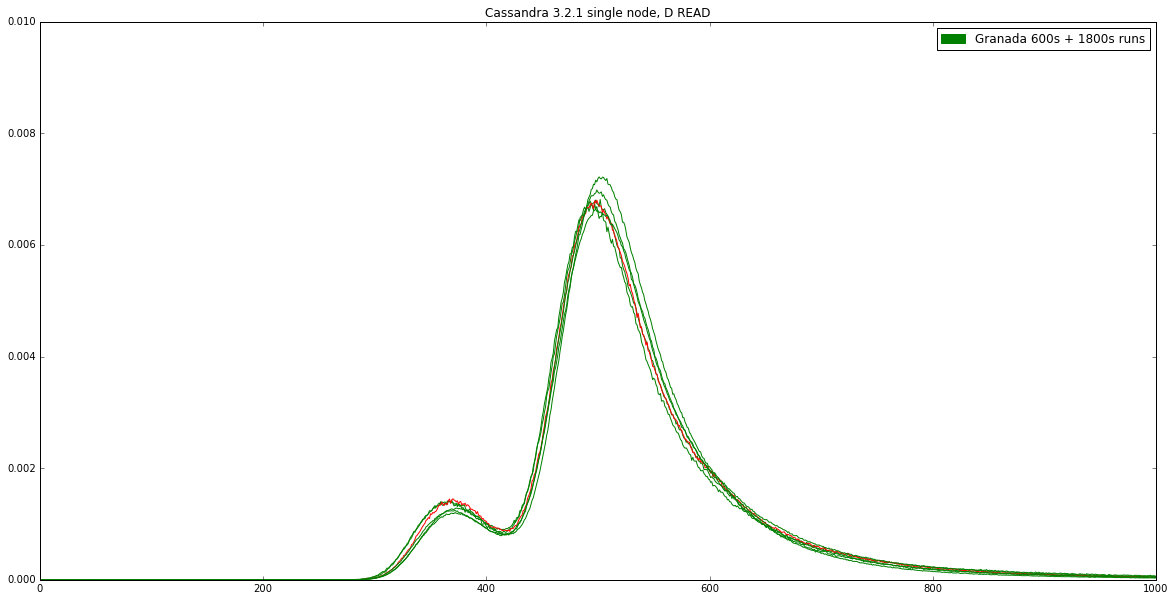

In [251]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1)

axes_limits = [0,1000, 0, 0.01]
colors = ['g']*6
colors[2] = 'r'
densities = runs['Granada'] 

if len(axes_limits) == 4: 
    ax.axis(axes_limits)
    ax = plt.gca()
    ax.set_autoscale_on(False)

for i in range(len(densities)):
    density = densities[i]
    if colors is None:
        ax.plot(density)
    else:
        ax.plot(density, colors[i])

#red_patch = mpatches.Patch(color='red', label='Dev 600s + 1800s runs')
#blue_patch = mpatches.Patch(color='blue', label='Granada 600s + 1800s runs')
green_patch = mpatches.Patch(color='green', label='Granada 600s + 1800s runs')
ax.legend(handles=[green_patch])#[red_patch, blue_patch, green_patch])
ax.set_title("Cassandra 3.2.1 single node, D READ", loc = 'center')

#fig.savefig('Highlander wrong.png')

In [122]:
def generateNoiseMeansPattern(lenght, scale=1):
    s = 0
    s_l = np.zeros(lenght)
    
    BD = stats.bernoulli(0.5)
    
    for i in range(lenght):
        s += (BD.rvs() - 0.5) * scale
        s_l[i] = s
    
    return s_l

In [156]:
d = densityFromSample(sampleFromDensity(runs['Highlander'][0], sample_size= 100000, noisy = True, noise_scale= 0.3))

In [177]:
d2 = densityFromSample(sampleFromDensity(runs['Highlander'][0], sample_size= 100000, noisy = True, noise_scale=0.1))

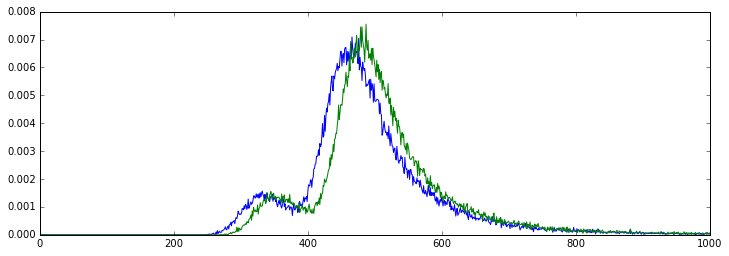

In [178]:
plotDensity([d[0], d2[0]],
             axes_limits = [0, 1000, 0, 0.008])

In [203]:
samples = []
for i in log_progress(range(20), every = 1):
    samples.append(sampleFromDensity(runs['Highlander'][0], sample_size= 100000, noisy = True, noise_scale= 0.1))

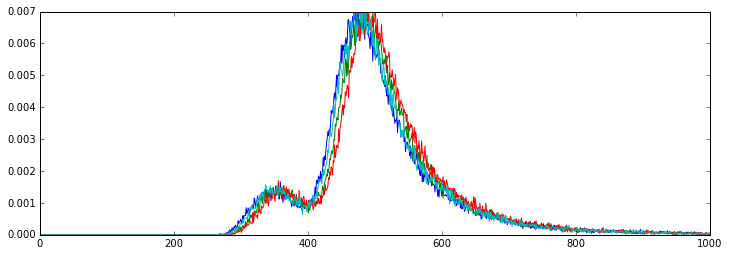

In [198]:
plotDensity(denn[:4]
            ,
            axes_limits = [0, 1000, 0, 0.007]
           )

In [193]:
denn = [den[i][0] for i in range(len(den))]

In [200]:
m = [np.mean(denn[i]) for i in range(20)]

In [201]:
m

[4.78148608587549e-05,
 4.1018909717379707e-05,
 3.6127167630057813e-05,
 1.8135654697134564e-05,
 4.1015544891513881e-05,
 3.9987204094689698e-05,
 2.0186115989422473e-05,
 3.8170852736850135e-05,
 5.7054829691333371e-05,
 4.112011184670422e-05,
 5.0950221633464103e-05,
 3.9813672014969937e-05,
 3.9618081692484448e-05,
 5.0100200400801596e-05,
 4.0003200256020489e-05,
 4.1101520756267974e-05,
 4.1933995890468405e-05,
 2.707605664311049e-05,
 5.1783957330019154e-05,
 4.362621062734491e-05]

NameError: name 'highlander_runs' is not defined

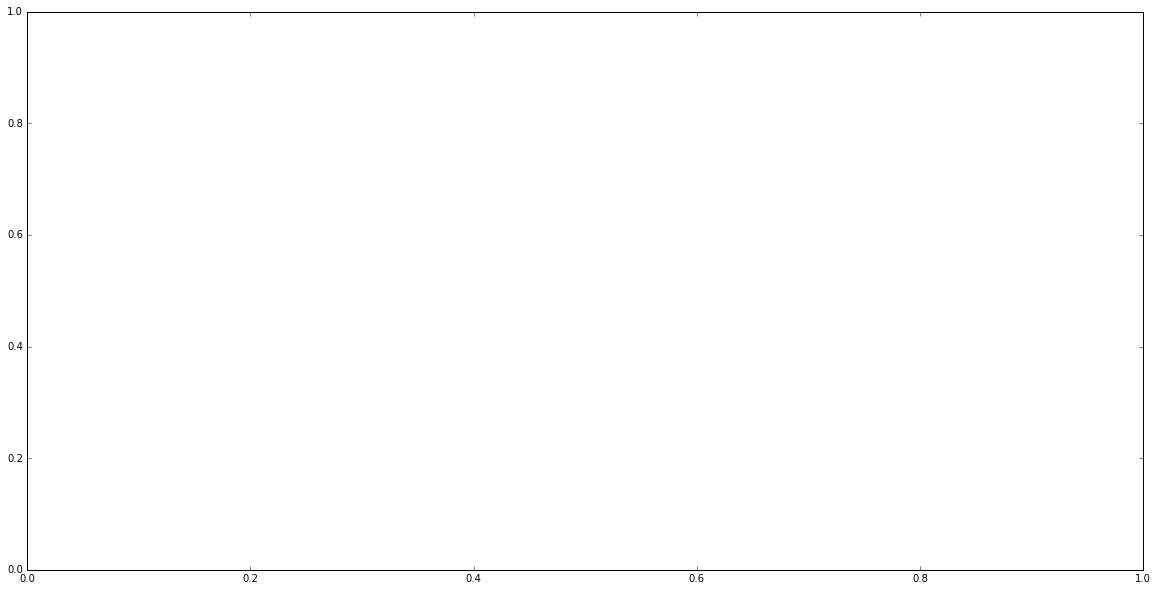

In [23]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1)

axes_limits = [0,700, 0, 0.015]
colors = ['r']*4 + ['g'] + ['r'] #+ ['g']*6 + ['b']*6
densities =  highlander_runs# + dev_runs

print len(densities)
if len(axes_limits) == 4:
    ax.axis(axes_limits)
    ax = plt.gca()
    ax.set_autoscale_on(False)

for i in range(len(densities)):
    density = densities[i]
    if colors is None:
        ax.plot(density)
    else:
        ax.plot(density, colors[i])

red_patch = mpatches.Patch(color='red', label='Oracle')
blue_patch = mpatches.Patch(color='blue', label='Dev')
green_patch = mpatches.Patch(color='green', label='Highlander')
ax.legend(handles=[red_patch, blue_patch, green_patch])
ax.set_title("Cassandra 3.2.1 single node, D READ", loc = 'center')


# NewBe Y

In [28]:
import data_processing_utils as utils

oracle_dir = "/home/anton/azul/New_config_latency_runs/OracleRD/"
dev_dir = "/home/anton/azul/New_config_latency_runs/DevRD/"
highlander_dir = "/home/anton/azul/New_config_latency_runs/HighlanderRD/"

oracle_runs = utils.read_multiple(oracle_dir, ["READ"], verbouse=False)
dev_runs = utils.read_multiple(dev_dir, ["READ"], verbouse=False)
highlander_runs = utils.read_multiple(highlander_dir, ["READ"], verbouse=False)

In [122]:
def plot_percentile(runs, perc, perc_dict, threashold = 0.99):
    perc_dict[perc] = []
    for run in runs:
        perc_dict[perc].append(pdfPercentiles(run, perc))
    
    perc_dict[perc] = drop_outliers(perc_dict[perc], threashold)
    
    mean = np.mean(perc_dict[perc])
    std = np.std(perc_dict[perc])
    
    x_vals = np.linspace(mean - 3*std, mean + 3*std, 6*std)
    y_vals = stats.norm.pdf(x_vals, mean, std)
    
    _ = plt.plot(x_vals, y_vals)
    _ = plt.plot(perc_dict[perc], [-max(y_vals) / 10 for _ in range(len(perc_dict[perc]))], 'o')
    normed_perc = [(perc_val - np.mean(perc_dict[perc])) / np.std(perc_dict[perc]) for perc_val in perc_dict[perc]]
    
    
    print stats.kstest(normed_perc, "norm")
    return perc_dict

In [80]:
dev_p = dict()
high_p = dict()

KstestResult(statistic=0.19403884992505971, pvalue=0.97759243899456794)


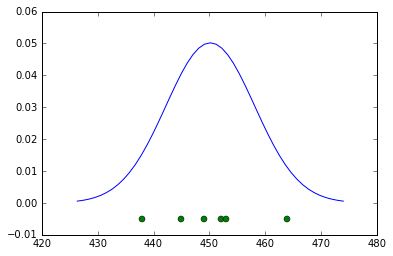

In [81]:
dev_p = plot_percentile(dev_runs, 99, dev_p)

In [82]:
normed_dev_p = dict()
normed_high_p = dict()

In [27]:
p = 99.99
dev_p[p] = [pdfPercentiles(o_r, p) for o_r in dev_runs]
high_p[p] = [pdfPercentiles(o_r, p) for o_r in highlander_runs]

NameError: name 'dev_runs' is not defined

In [139]:
normed_dev_p[p] = [(per - np.mean(dev_p[p])) / np.std(dev_p[p]) for per in dev_p[p]]
normed_high_p[p] = [(per - np.mean(high_p[p])) / np.std(high_p[p]) for per in high_p[p]]

In [55]:
print stats.kstest(normed_high_p[99], "norm")
#print stats.kstest(normed_dev_p[p], "norm")

KeyError: 99

In [143]:
print np.mean(dev_p[p])
print np.mean(high_p[p])

1944.5
2146.66666667


In [145]:
print np.std(dev_p[p])
print np.std(high_p[p])

510.607073329
592.137277627


In [22]:
ls = np.linspace(np.mean(dev_p[p]) - 3 *np.std(dev_p[p]), np.mean(dev_p[p]) + 3 *np.std(dev_p[p]), int(6* np.std(dev_p[p])))
plt.plot(ls, stats.norm.pdf(ls, np.mean(dev_p[p]), np.std(dev_p[p])))
plt.plot(ls, stats.norm.pdf(ls, np.mean(dev_p_halfs[p]), np.std(dev_p_halfs[p])))

NameError: name 'dev_p' is not defined

In [93]:
normed_dev_p = dict()

In [43]:
dev_dir = "/home/anton/azul/New_config_latency_runs/DevRD_halfs/"

dev_runs_halfs = utils.read_multiple(dev_dir, ["READ"], verbouse=False)

In [66]:
high_dir = "/home/anton/azul/New_config_latency_runs/HighRD_halfs/"


high_runs_halfs = utils.read_multiple(high_dir, ["READ"], verbouse=False)

In [67]:
dev_p_halfs = dict()
high_p_halfs = dict()

KstestResult(statistic=0.20908785329119595, pvalue=0.61487593754019376)


{99.9: [601, 597, 595, 554, 575, 553, 572, 583, 590, 572, 612, 566],
 99.99: [1686,
  2600,
  2352,
  1293,
  1708,
  1186,
  1971,
  1916,
  2390,
  4208,
  1865,
  1463]}

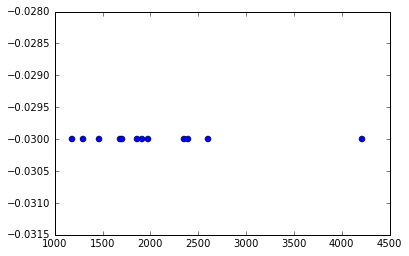

In [70]:
plot_percentile(high_runs_halfs, 99.99, dev_p_halfs)

In [135]:
p = 99.99
dev_p_halfs[p] = [pdfPercentiles(o_r, p) for o_r in dev_runs_halfs]

In [142]:
np.mean(dev_p_halfs[p])

1848.5833333333333

In [144]:
np.std(dev_p_halfs[p])

719.51296702854654

In [123]:
def read_and_plot(runs_dir, perc, threashold = 0.99):
    runs = utils.read_multiple(runs_dir, ["READ"], verbouse=False)
    perc_dict = dict()
    plot_percentile(runs, perc, perc_dict, threashold)

KstestResult(statistic=0.14552244928268676, pvalue=0.97397493654436551)
KstestResult(statistic=0.20811227385080711, pvalue=0.67870355925379089)


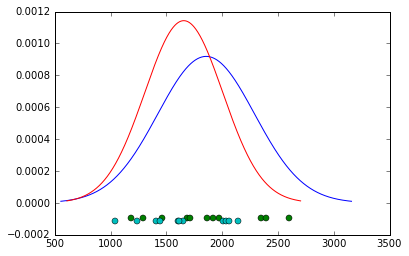

In [129]:
read_and_plot("/home/anton/azul/New_config_latency_runs/HighRD_halfs/", 99.99)
read_and_plot("/home/anton/azul/New_config_latency_runs/DevRD_halfs/", 99.99)


KstestResult(statistic=0.2604204872895638, pvalue=0.33155438031761042)
KstestResult(statistic=0.20908785329119595, pvalue=0.61487593754019376)


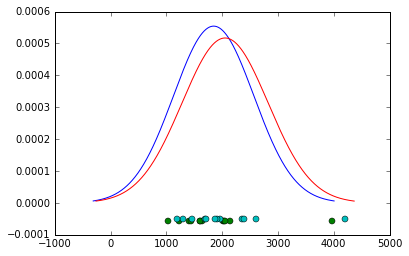

In [130]:
read_and_plot("/home/anton/azul/New_config_latency_runs/DevRD_halfs/", 99.99, threashold = 1)
read_and_plot("/home/anton/azul/New_config_latency_runs/HighRD_halfs/", 99.99, threashold = 1)

KstestResult(statistic=0.12792494442379165, pvalue=0.98942744804883032)
KstestResult(statistic=0.19155307715348269, pvalue=0.73692456895586256)


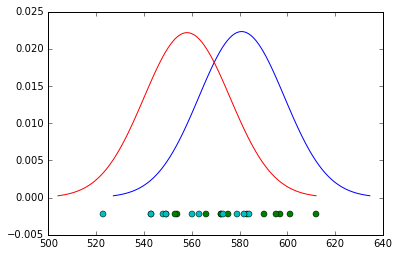

In [131]:
read_and_plot("/home/anton/azul/New_config_latency_runs/HighRD_halfs/", 99.9)
read_and_plot("/home/anton/azul/New_config_latency_runs/DevRD_halfs/", 99.9
             )


In [120]:
def drop_outliers(vals, threashold = None):
    if threashold == None:
        threashold = 1.0 / len(vals)
    
    new_vals = []
    
    for i in range(len(vals)):
        mean = np.mean(np.hstack((vals[:i], vals[i:])))
        std = np.std(np.hstack((vals[:i], vals[i:])))
        check_val = vals[i]
        
        interval = stats.norm.interval(threashold, mean, std)
        #print np.hstack((vals[:i], vals[i:]))
        #print interval
        #print check_val
        
        if check_val >= interval[0] and check_val <= interval[1]:
            new_vals.append(check_val)
        
    return new_vals
            
        

In [117]:
drop_outliers(dev_p_halfs[99.99], 0.99)

[ 1686.  2600.  2352.  1293.  1708.  1186.  1971.  1916.  2390.  4208.
  1865.  1463.]
(66.527017418726018, 4039.8063159146068)
1686
[1686 2600 2352 1293 1708 1186 1971 1916 2390 4208 1865 1463]
(66.527017418726018, 4039.8063159146068)
2600
[1686 2600 2352 1293 1708 1186 1971 1916 2390 4208 1865 1463]
(66.527017418726018, 4039.8063159146068)
2352
[1686 2600 2352 1293 1708 1186 1971 1916 2390 4208 1865 1463]
(66.527017418726018, 4039.8063159146068)
1293
[1686 2600 2352 1293 1708 1186 1971 1916 2390 4208 1865 1463]
(66.527017418726018, 4039.8063159146068)
1708
[1686 2600 2352 1293 1708 1186 1971 1916 2390 4208 1865 1463]
(66.527017418726018, 4039.8063159146068)
1186
[1686 2600 2352 1293 1708 1186 1971 1916 2390 4208 1865 1463]
(66.527017418726018, 4039.8063159146068)
1971
[1686 2600 2352 1293 1708 1186 1971 1916 2390 4208 1865 1463]
(66.527017418726018, 4039.8063159146068)
1916
[1686 2600 2352 1293 1708 1186 1971 1916 2390 4208 1865 1463]
(66.527017418726018, 4039.8063159146068)
2390
[16

[1686, 2600, 2352, 1293, 1708, 1186, 1971, 1916, 2390, 1865, 1463]

In [101]:
dev_p_halfs

{99.9: [601, 597, 595, 554, 575, 553, 572, 583, 590, 572, 612, 566],
 99.99: [1686,
  2600,
  2352,
  1293,
  1708,
  1186,
  1971,
  1916,
  2390,
  4208,
  1865,
  1463]}

In [97]:
stats.norm.interval(0.99)

(-2.5758293035489004, 2.5758293035489004)